# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [4]:
# Update the PATH to include the user installation directory. 
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

# Restart the Kernel before you move on to the next step.

#### Important: Restart the Kernel before you move on to the next step.

In [5]:
# Install requirements
!python -m pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


## Imports

In [6]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [7]:
from torch.utils.data import DataLoader
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1307], std=[0.3081])
])

# Create training set and define training dataloader
training_data = torchvision.datasets.MNIST(train=True, download=True, transform=transform, root="data")
train_loader = DataLoader(training_data, batch_size=64, shuffle=True)


# Create test set and define test dataloader
test_data = torchvision.datasets.MNIST(train=False, download=True, transform=transform, root="data" )
test_loader = DataLoader(test_data, batch_size=64)

In [8]:
image, label = training_data[0]
print(image.size())

torch.Size([1, 28, 28])


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

Two main transforms have been used here:
1. transforms.ToTensor(): This transform converts PIL images or NumPy arrays into PyTorch tensors, which are the required input format for PyTorch models.
2. Normalize to adjusts pixel values so that they have a specified mean and standard deviation. This can increase speed training and we are using the mean and std for gray images for the MNIST dataset.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [9]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

7


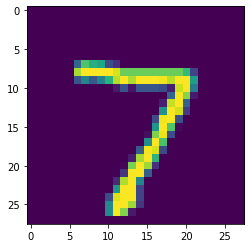

2


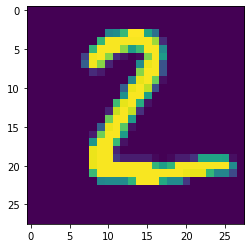

1


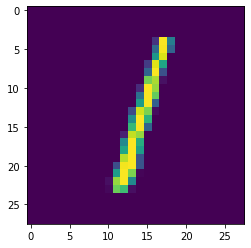

0


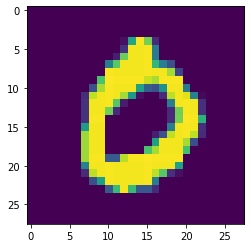

4


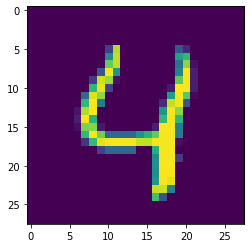

In [10]:
# Explore data
show5(test_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [11]:
## YOUR CODE HERE ##
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.layer1 = nn.Linear(28*28*1, 64)
        self.layer2 = nn.Linear(64, 128)
        self.layer3 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.layer3(x)
        x = F.softmax(x, dim=1) 
        return x

In [12]:
net = Net()

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [13]:
## YOUR CODE HERE ##
# optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

# loss function
criterion = nn.CrossEntropyLoss()

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [14]:
## YOUR CODE HERE ##
# Set number of epochs and device (GPU or CPU) for training
num_epochs = 7
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)  # Move the model to the appropriate device

# Lists to store loss history for further analysis or plotting
train_loss_history = []
val_loss_history = []

# Training loop
for epoch in range(num_epochs):
    net.train()  # Set model to training mode (important for things like dropout)
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    # Iterate over each batch of data
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)  # Move data to the appropriate device
        
        optimizer.zero_grad()  # Clear gradients to prevent accumulation from previous iterations
        outputs = net(inputs)  # Forward pass: compute predicted outputs by passing inputs to the model
        loss = criterion(outputs, labels)  # Calculate the loss based on the model's output and actual labels
        loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()  # Perform a single optimization step (parameter update)

        _, preds = torch.max(outputs.data, 1)  # Find the predicted classes by taking the index of the max log-probability
        train_correct += (preds == labels).sum().item()  # Sum up the number of correct predictions
        train_total += labels.size(0)  # Count total predictions
        train_loss += loss.item()  # Sum up the loss for averaging later

        if (i + 1) % 250 == 0:  # Optionally print the loss every 250 batches
            print(f'Batch {i + 1}: Loss = {train_loss / (i + 1):.5f}')

    # Calculate and store the average loss and accuracy for this epoch
    epoch_accuracy = train_correct / train_total
    epoch_loss = train_loss / len(train_loader)
    train_loss_history.append(epoch_loss)
    print(f'Epoch {epoch + 1}: Accuracy = {epoch_accuracy:.2f}, Loss = {epoch_loss:.5f}')

    # Validation phase: Evaluate the model on the test data
    net.eval()  # Set the model to evaluation mode (impacts certain modules like dropout)
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():  # Disable gradient calculation for efficiency and to prevent changes to weights
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs.data, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
            val_loss += loss.item()

    # Calculate and store the average validation loss and accuracy
    val_accuracy = val_correct / val_total
    val_epoch_loss = val_loss / len(test_loader)
    val_loss_history.append(val_epoch_loss)
    print(f'Validation: Accuracy = {val_accuracy:.2f}, Loss = {val_epoch_loss:.5f}')

Batch 250: Loss = 2.08902
Batch 500: Loss = 1.90338
Batch 750: Loss = 1.80053
Epoch 1: Accuracy = 0.74, Loss = 1.75341
Validation: Accuracy = 0.92, Loss = 1.55322
Batch 250: Loss = 1.55539
Batch 500: Loss = 1.55238
Batch 750: Loss = 1.54914
Epoch 2: Accuracy = 0.92, Loss = 1.54668
Validation: Accuracy = 0.93, Loss = 1.53235
Batch 250: Loss = 1.53280
Batch 500: Loss = 1.53128
Batch 750: Loss = 1.53008
Epoch 3: Accuracy = 0.94, Loss = 1.52835
Validation: Accuracy = 0.94, Loss = 1.52195
Batch 250: Loss = 1.51916
Batch 500: Loss = 1.51768
Batch 750: Loss = 1.51726
Epoch 4: Accuracy = 0.95, Loss = 1.51756
Validation: Accuracy = 0.95, Loss = 1.51484
Batch 250: Loss = 1.51306
Batch 500: Loss = 1.51280
Batch 750: Loss = 1.51183
Epoch 5: Accuracy = 0.95, Loss = 1.51086
Validation: Accuracy = 0.95, Loss = 1.51304
Batch 250: Loss = 1.50430
Batch 500: Loss = 1.50457
Batch 750: Loss = 1.50511
Epoch 6: Accuracy = 0.96, Loss = 1.50484
Validation: Accuracy = 0.96, Loss = 1.50559
Batch 250: Loss = 1.50

Plot the training loss (and validation loss/accuracy, if recorded).

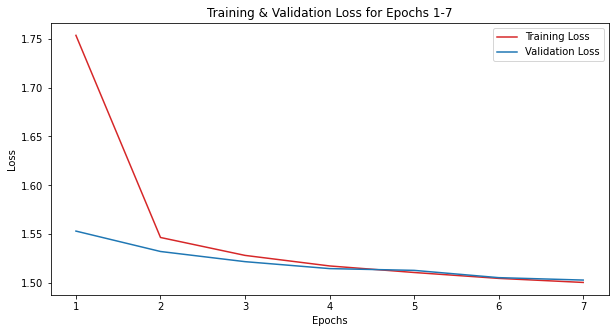

In [15]:
## YOUR CODE HERE ##
plt.figure(figsize=(10, 5))
plt.plot(range(1, 8), train_loss_history[:7], label='Training Loss', color='tab:red')  
plt.plot(range(1, 8), val_loss_history[:7], label='Validation Loss', color='tab:blue')  
plt.title('Training & Validation Loss for Epochs 1-7')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, 8))
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [16]:
## YOUR CODE HERE ##
# I will copy the code from the validation phase here
net.eval()  # Set the model to evaluation mode

correct = 0
total = 0

with torch.no_grad():  # No gradients needed
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)  # Move data to the appropriate device
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)  # Get the indices of the max log-probability which are the predicted classes
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the network on the test images: {accuracy:.2f}%')

Accuracy of the network on the test images: 95.99%


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [17]:
## YOUR CODE HERE ##
# I will set the hyperparameter number of epochs to 5 using the values detected in the graph
num_epochs = 5 # since we want to prevent overfitting

net2 = Net()
# optimizer
optimizer = optim.SGD(net2.parameters(), lr=0.01, momentum=0.9)
# loss function
criterion = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net2.to(device)  # Move the model to the appropriate device

# Lists to store loss history for further analysis or plotting
train_loss_history = []
val_loss_history = []

# Training loop
for epoch in range(num_epochs):
    net2.train()  # Set model to training mode (important for things like dropout)
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    # Iterate over each batch of data
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)  # Move data to the appropriate device
        
        optimizer.zero_grad()  # Clear gradients to prevent accumulation from previous iterations
        outputs = net2(inputs)  # Forward pass: compute predicted outputs by passing inputs to the model
        loss = criterion(outputs, labels)  # Calculate the loss based on the model's output and actual labels
        loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()  # Perform a single optimization step (parameter update)

        _, preds = torch.max(outputs.data, 1)  # Find the predicted classes by taking the index of the max log-probability
        train_correct += (preds == labels).sum().item()  # Sum up the number of correct predictions
        train_total += labels.size(0)  # Count total predictions
        train_loss += loss.item()  # Sum up the loss for averaging later

        if (i + 1) % 250 == 0:  # Optionally print the loss every 250 batches
            print(f'Batch {i + 1}: Loss = {train_loss / (i + 1):.5f}')

    # Calculate and store the average loss and accuracy for this epoch
    epoch_accuracy = train_correct / train_total
    epoch_loss = train_loss / len(train_loader)
    train_loss_history.append(epoch_loss)
    print(f'Epoch {epoch + 1}: Accuracy = {epoch_accuracy:.2f}, Loss = {epoch_loss:.5f}')

    # Validation phase: Evaluate the model on the test data
    net2.eval()  # Set the model to evaluation mode (impacts certain modules like dropout)
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():  # Disable gradient calculation for efficiency and to prevent changes to weights
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net2(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs.data, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
            val_loss += loss.item()

    # Calculate and store the average validation loss and accuracy
    val_accuracy = val_correct / val_total
    val_epoch_loss = val_loss / len(test_loader)
    val_loss_history.append(val_epoch_loss)
    print(f'Validation: Accuracy = {val_accuracy:.2f}, Loss = {val_epoch_loss:.5f}')

Batch 250: Loss = 2.08866
Batch 500: Loss = 1.87036
Batch 750: Loss = 1.77441
Epoch 1: Accuracy = 0.76, Loss = 1.73215
Validation: Accuracy = 0.92, Loss = 1.54996
Batch 250: Loss = 1.55374
Batch 500: Loss = 1.55224
Batch 750: Loss = 1.54992
Epoch 2: Accuracy = 0.92, Loss = 1.54853
Validation: Accuracy = 0.93, Loss = 1.53579
Batch 250: Loss = 1.53503
Batch 500: Loss = 1.53287
Batch 750: Loss = 1.53349
Epoch 3: Accuracy = 0.93, Loss = 1.53233
Validation: Accuracy = 0.93, Loss = 1.52838
Batch 250: Loss = 1.52503
Batch 500: Loss = 1.52422
Batch 750: Loss = 1.52283
Epoch 4: Accuracy = 0.94, Loss = 1.52224
Validation: Accuracy = 0.94, Loss = 1.52117
Batch 250: Loss = 1.51371
Batch 500: Loss = 1.51635
Batch 750: Loss = 1.51527
Epoch 5: Accuracy = 0.95, Loss = 1.51479
Validation: Accuracy = 0.95, Loss = 1.51191


## Saving your model
Using `torch.save`, save your model for future loading.

In [19]:
## YOUR CODE HERE ##
torch.save(net2, 'model_full.pth')